In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
# #        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [3]:

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from matplotlib import pyplot as plt

import os
from PIL import Image


In [4]:
import os
from PIL import Image


class DenoisingDataset(Dataset):
    def __init__(self, root_dir, subset='Train', transform=None):
        self.root_dir = root_dir
        self.subset = subset
        self.transform = transform
        self.data = self._load_data_paths()

    def _load_data_paths(self):
        data = []

        # Loop through each object type in the root directory
        for object_type in os.listdir(self.root_dir):
            object_path = os.path.join(self.root_dir, object_type)
            if not os.path.isdir(object_path):
                continue

            # Set paths for each directory
            gt_dir = os.path.join(object_path, self.subset, "GT_clean_image")
            mask_dir = os.path.join(object_path, self.subset, "Defect_mask")
            degraded_dir = os.path.join(object_path, self.subset, "Degraded_image")


            # Loop through each defect type within the GT_clean_image directory
            for defect_type in os.listdir(gt_dir):
                gt_subdir = os.path.join(gt_dir, defect_type)
                degraded_subdir = os.path.join(degraded_dir, defect_type)
                mask_subdir = os.path.join(mask_dir, defect_type)


                # Ensure the defect type exists in all directories
                if not (os.path.isdir(gt_subdir) and os.path.isdir(degraded_subdir) and os.path.isdir(mask_subdir)):
                    continue

                # For each clean image in the defect type, get the corresponding degraded and mask images
                for file_name1, file_name2, file_name3 in zip(sorted(os.listdir(gt_subdir)), sorted(os.listdir(degraded_subdir)), sorted(os.listdir(mask_subdir))):
                    gt_path = os.path.join(gt_subdir, file_name1)
                    degraded_path = os.path.join(degraded_subdir, file_name2)
                    mask_path = os.path.join(mask_subdir, file_name3)


                    # Check if all three files exist
                    if os.path.exists(gt_path) and os.path.exists(degraded_path) and os.path.exists(mask_path):
                        data.append((degraded_path, gt_path, mask_path))

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        degraded_path, gt_path, mask_path = self.data[idx]

        # Load images
        degraded_image = Image.open(degraded_path).convert("RGB")
        gt_image = Image.open(gt_path).convert("RGB")
        defect_mask = Image.open(mask_path).convert("L")  # Load mask as grayscale

        # Apply transformations if specified
        if self.transform:
            degraded_image = self.transform(degraded_image)
            gt_image = self.transform(gt_image)
            defect_mask = self.transform(defect_mask)

        return degraded_image, gt_image, defect_mask


In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Adjust size as needed for your model
    transforms.ToTensor()
])


In [6]:
# Define the root directory of your dataset
DATASET_PATH = "/kaggle/input/denoising-ds/Denoising_Dataset_train_val"

# Load train and validation datasets across all object categories
train_dataset = DenoisingDataset(DATASET_PATH, subset='Train', transform=transform)
val_dataset = DenoisingDataset(DATASET_PATH, subset='Val', transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)


In [7]:
print(len(train_dataset))
print(len(val_dataset))

932
88


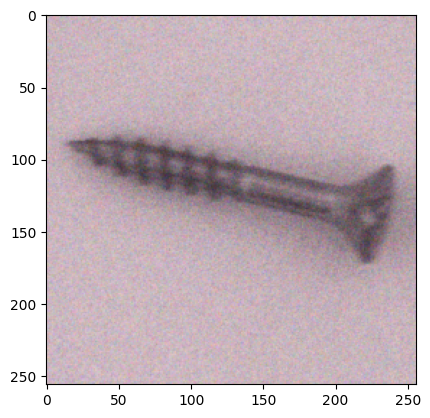

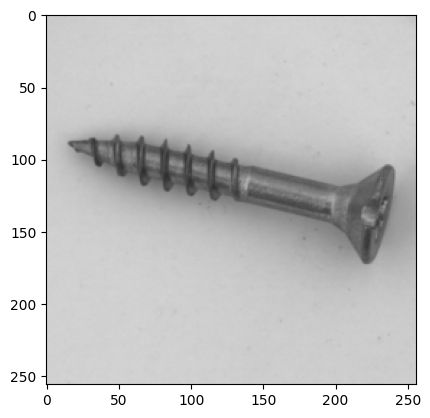

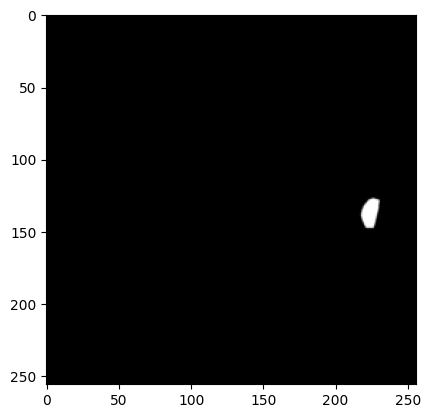

In [8]:
degraded_image, gt_image, defect_mask = train_dataset[100]
plt.imshow(degraded_image.permute(1, 2, 0))
plt.show()
plt.imshow(gt_image.permute(1, 2, 0))
plt.show()
plt.imshow(defect_mask.squeeze(), cmap='gray')
plt.show()

In [9]:
!pip install einops
!pip install thop

In [10]:
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from einops import rearrange
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from thop import profile

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops



In [11]:
class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        # assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


In [12]:
class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


In [13]:
# Dual up-sample
class UpSample(nn.Module):
    def __init__(self, input_resolution, in_channels, scale_factor):
        super(UpSample, self).__init__()
        self.input_resolution = input_resolution
        self.factor = scale_factor


        if self.factor == 2:
            self.conv = nn.Conv2d(in_channels, in_channels//2, 1, 1, 0, bias=False)
            self.up_p = nn.Sequential(nn.Conv2d(in_channels, 2*in_channels, 1, 1, 0, bias=False),
                                      nn.PReLU(),
                                      nn.PixelShuffle(scale_factor),
                                      nn.Conv2d(in_channels//2, in_channels//2, 1, stride=1, padding=0, bias=False))

            self.up_b = nn.Sequential(nn.Conv2d(in_channels, in_channels, 1, 1, 0),
                                      nn.PReLU(),
                                      nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=False),
                                      nn.Conv2d(in_channels, in_channels // 2, 1, stride=1, padding=0, bias=False))
        elif self.factor == 4:
            self.conv = nn.Conv2d(2*in_channels, in_channels, 1, 1, 0, bias=False)
            self.up_p = nn.Sequential(nn.Conv2d(in_channels, 16 * in_channels, 1, 1, 0, bias=False),
                                      nn.PReLU(),
                                      nn.PixelShuffle(scale_factor),
                                      nn.Conv2d(in_channels, in_channels, 1, stride=1, padding=0, bias=False))

            self.up_b = nn.Sequential(nn.Conv2d(in_channels, in_channels, 1, 1, 0),
                                      nn.PReLU(),
                                      nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=False),
                                      nn.Conv2d(in_channels, in_channels, 1, stride=1, padding=0, bias=False))

    def forward(self, x):
        """
        x: B, L = H*W, C
        """
        if type(self.input_resolution) == int:
            H = self.input_resolution
            W = self.input_resolution

        elif type(self.input_resolution) == tuple:
            H, W = self.input_resolution

        B, L, C = x.shape
        x = x.view(B, H, W, C)  # B, H, W, C
        x = x.permute(0, 3, 1, 2)  # B, C, H, W
        x_p = self.up_p(x)  # pixel shuffle
        x_b = self.up_b(x)  # bilinear
        out = self.conv(torch.cat([x_p, x_b], dim=1))
        out = out.permute(0, 2, 3, 1)  # B, H, W, C
        if self.factor == 2:
            out = out.view(B, -1, C // 2)

        return out


In [14]:
class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops



In [15]:
class BasicLayer_up(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, upsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if upsample is not None:
            self.upsample = UpSample(input_resolution, in_channels=dim, scale_factor=2)
        else:
            self.upsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.upsample is not None:
            x = self.upsample(x)
        return x



In [16]:
class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        # assert H == self.img_size[0] and W == self.img_size[1], \
        #    f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops


In [17]:
import h5py

In [18]:
class SUNet(nn.Module):
    r""" Swin Transformer
        A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
          https://arxiv.org/pdf/2103.14030

    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3

        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, out_chans=3,
                 embed_dim=96, depths=[2, 2, 2, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, final_upsample="Dual up-sample", **kwargs):
        super(SUNet, self).__init__()

        self.out_chans = out_chans
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.num_features_up = int(embed_dim * 2)
        self.mlp_ratio = mlp_ratio
        self.final_upsample = final_upsample
        self.prelu = nn.PReLU()
        self.conv_first = nn.Conv2d(in_chans, embed_dim, 3, 1, 1)

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build encoder and bottleneck layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               drop=drop_rate, attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint)
            self.layers.append(layer)

        # build decoder layers
        self.layers_up = nn.ModuleList()
        self.concat_back_dim = nn.ModuleList()
        for i_layer in range(self.num_layers):
            concat_linear = nn.Linear(2 * int(embed_dim * 2 ** (self.num_layers - 1 - i_layer)),
                                      int(embed_dim * 2 ** (
                                              self.num_layers - 1 - i_layer))) if i_layer > 0 else nn.Identity()
            if i_layer == 0:
                layer_up = UpSample(input_resolution=patches_resolution[0] // (2 ** (self.num_layers - 1 - i_layer)),
                                    in_channels=int(embed_dim * 2 ** (self.num_layers - 1 - i_layer)), scale_factor=2)
            else:
                layer_up = BasicLayer_up(dim=int(embed_dim * 2 ** (self.num_layers - 1 - i_layer)),
                                         input_resolution=(
                                             patches_resolution[0] // (2 ** (self.num_layers - 1 - i_layer)),
                                             patches_resolution[1] // (2 ** (self.num_layers - 1 - i_layer))),
                                         depth=depths[(self.num_layers - 1 - i_layer)],
                                         num_heads=num_heads[(self.num_layers - 1 - i_layer)],
                                         window_size=window_size,
                                         mlp_ratio=self.mlp_ratio,
                                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                                         drop=drop_rate, attn_drop=attn_drop_rate,
                                         drop_path=dpr[sum(depths[:(self.num_layers - 1 - i_layer)]):sum(
                                             depths[:(self.num_layers - 1 - i_layer) + 1])],
                                         norm_layer=norm_layer,
                                         upsample=UpSample if (i_layer < self.num_layers - 1) else None,
                                         use_checkpoint=use_checkpoint)
            self.layers_up.append(layer_up)
            self.concat_back_dim.append(concat_linear)

        self.norm = norm_layer(self.num_features)
        self.norm_up = norm_layer(self.embed_dim)

        if self.final_upsample == "Dual up-sample":
            self.up = UpSample(input_resolution=(img_size // patch_size, img_size // patch_size),
                               in_channels=embed_dim, scale_factor=4)
            self.output = nn.Conv2d(in_channels=embed_dim, out_channels=self.out_chans, kernel_size=3, stride=1,
                                    padding=1, bias=False)  # kernel = 1

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    # Encoder and Bottleneck
    def forward_features(self, x):
        residual = x
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)
        x_downsample = []

        for layer in self.layers:
            x_downsample.append(x)
            x = layer(x)

        x = self.norm(x)  # B L C

        return x, residual, x_downsample

    # Dencoder and Skip connection
    def forward_up_features(self, x, x_downsample):
        for inx, layer_up in enumerate(self.layers_up):
            if inx == 0:
                x = layer_up(x)
            else:
                x = torch.cat([x, x_downsample[3 - inx]], -1)  # concat last dimension
                x = self.concat_back_dim[inx](x)
                x = layer_up(x)

        x = self.norm_up(x)  # B L C

        return x

    def up_x4(self, x):
        H, W = self.patches_resolution
        B, L, C = x.shape
        assert L == H * W, "input features has wrong size"

        if self.final_upsample == "Dual up-sample":
            x = self.up(x)
            # x = x.view(B, 4 * H, 4 * W, -1)
            x = x.permute(0, 3, 1, 2)  # B,C,H,W

        return x

    def forward(self, x):
        x = self.conv_first(x)
        x, residual, x_downsample = self.forward_features(x)
        x = self.forward_up_features(x, x_downsample)
        x = self.up_x4(x)
        out = self.output(x)
        # x = x + residual
        return out

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        flops += self.num_features * self.out_chans
        return flops

    def save_h5(self, filename):
        """Save the model parameters to an HDF5 file."""
        with h5py.File(filename, 'w') as f:
            for name, param in self.named_parameters():
                f.create_dataset(name, data=param.detach().cpu().numpy())

    def load_h5(self, filename):
        """Load the model parameters from an HDF5 file."""
        with h5py.File(filename, 'r') as f:
            for name, param in self.named_parameters():
                if name in f:
                    param.data.copy_(torch.tensor(f[name][:]))
 

In [19]:
height = 64
width = 64
x = torch.randn((1, 3, height, width))  # .cuda()
model = SUNet(img_size=256, patch_size=4, in_chans=3, out_chans=3,
              embed_dim=96, depths=[8, 8, 8, 8],
              num_heads=[8, 8, 8, 8],
              window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=2,
              drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
              norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
              use_checkpoint=False, final_upsample="Dual up-sample")  # .cuda()
# print(model)
print('input image size: (%d, %d)' % (height, width))
print('output image size: ', x.shape)


/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


input image size: (64, 64)
output image size:  torch.Size([1, 3, 64, 64])


In [20]:

# SSIM Loss in Defect Regions
def ssim_loss_in_defect(img1, img2, defect_mask, C1=0.01 * 2, C2=0.03 * 2):
    mu1 = torch.nn.functional.avg_pool2d(img1, 3, 1, 1)
    mu2 = torch.nn.functional.avg_pool2d(img2, 3, 1, 1)

    sigma1 = torch.nn.functional.avg_pool2d(img1 * 2, 3, 1, 1) - mu1 * 2
    sigma2 = torch.nn.functional.avg_pool2d(img2 * 2, 3, 1, 1) - mu2 * 2
    sigma12 = torch.nn.functional.avg_pool2d(img1 * img2, 3, 1, 1) - mu1 * mu2

    ssim_map = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / ((mu1 * 2 + mu2 * 2 + C1) * (sigma1 + sigma2 + C2))

    # Apply defect mask to only include defect areas in SSIM calculation
    ssim_in_defect = ssim_map * defect_mask
    return torch.clamp((1 - ssim_in_defect) / 2, 0, 1).mean()

# PSNR Loss over Entire Image
def psnr_loss_in(img1, img2):
    mse = nn.MSELoss()(img1, img2)
    psnr = 10 * torch.log10(1 / mse)
    return -psnr


In [21]:
# Combined Loss Function
class DefectFocusedCombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(DefectFocusedCombinedLoss, self).__init__()
        self.alpha = alpha

    def forward(self, output, target, defect_mask):
        psnr = psnr_loss_in(output, target)
        ssim = ssim_loss_in_defect(output, target, defect_mask)
        return self.alpha * psnr + (1 - self.alpha) * ssim


In [22]:
torch.cuda.empty_cache()

In [23]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast

# Example Training Loop
def train(model, dataloader, criterion, optimizer, epochs=20):
    model.train()
    scaler = GradScaler()  # For mixed precision training
    best_loss = float('inf')
    patience = 5
    counter = 0

    for epoch in range(epochs):
        epoch_loss = 0
        psnr_loss = 0
        ssim_loss = 0
        count = 0

        for degraded, clean, defect_mask in dataloader:
            degraded, clean, defect_mask = degraded.to(device), clean.to(device), defect_mask.to(device)

            optimizer.zero_grad()
            with autocast():  # Mixed precision context
                output = model(degraded)
                loss = criterion(output, clean, defect_mask)

            scaler.scale(loss).backward()  # Scale the loss for mixed precision
            scaler.step(optimizer)
            scaler.update()

            psnr_loss += -psnr_loss_in(output, clean)
            ssim_loss += 1 - ssim_loss_in_defect(output, clean, defect_mask)

            epoch_loss += loss.item()

            count += 1
            if count % 100 == 0:  # Logging every 100 batches
                print(f'Avg PSNR Loss: {psnr_loss / 100:.4f}, Avg SSIM Index: {ssim_loss / 100:.4f}')
                psnr_loss = 0
                ssim_loss = 0

        # Check for best loss for early stopping
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            counter = 0  # Reset counter if loss improved
        else:
            counter += 1  # Increment counter if loss did not improve
            if counter >= patience:
                print("Early stopping!")
                break

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss / len(dataloader):.4f}")

# Setup and Example Execution
# Replace 'degraded_images', 'clean_images', 'defect_masks' with your dataset paths
# dataset = NoisyImageDataset(degraded_images, clean_images, defect_masks, transform=transform)
# train_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)
criterion = DefectFocusedCombinedLoss(alpha=0.5)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model
# train(model, train_loader, criterion, optimizer, epochs=10)


In [24]:
device = "cuda"
model.to(device)
train(model, train_loader, criterion, optimizer, epochs=25)


/tmp/ipykernel_2967/418675528.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision training
/tmp/ipykernel_2967/418675528.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision context


Avg PSNR Loss: 19.5908, Avg SSIM Index: 0.5035
Epoch [1/25], Loss: -9.7453
Avg PSNR Loss: 23.2082, Avg SSIM Index: 0.5036
Epoch [2/25], Loss: -11.4644
Avg PSNR Loss: 24.3239, Avg SSIM Index: 0.5036
Epoch [3/25], Loss: -11.9008
Avg PSNR Loss: 24.4188, Avg SSIM Index: 0.5036
Epoch [4/25], Loss: -11.9926
Avg PSNR Loss: 24.8355, Avg SSIM Index: 0.5036
Epoch [5/25], Loss: -12.1740
Avg PSNR Loss: 25.4057, Avg SSIM Index: 0.5037
Epoch [6/25], Loss: -12.4242
Avg PSNR Loss: 25.5431, Avg SSIM Index: 0.5035
Epoch [7/25], Loss: -12.4875
Avg PSNR Loss: 25.6905, Avg SSIM Index: 0.5037
Epoch [8/25], Loss: -12.6123
Avg PSNR Loss: 25.9246, Avg SSIM Index: 0.5036
Epoch [9/25], Loss: -12.7084
Avg PSNR Loss: 26.1470, Avg SSIM Index: 0.5037
Epoch [10/25], Loss: -12.8085
Avg PSNR Loss: 25.6488, Avg SSIM Index: 0.5036
Epoch [11/25], Loss: -12.5940
Avg PSNR Loss: 26.1301, Avg SSIM Index: 0.5036
Epoch [12/25], Loss: -12.8336
Avg PSNR Loss: 26.3540, Avg SSIM Index: 0.5035
Epoch [13/25], Loss: -12.9409
Avg PSNR 

In [25]:
model.save_h5('/kaggle/working/model.h5')


In [26]:
from IPython.display import FileLink


In [27]:
!zip -r file.zip /kaggle/working


  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/model.h5 (deflated 7%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)


In [28]:
FileLink(r'file.zip')

/kaggle/working/file.zip

In [30]:
with torch.no_grad():
    model.eval()
    psnr_score = 0
    ssim_index = 0
    for degraded, clean, defect_mask in val_loader:
        degraded, clean, defect_mask = degraded.to(device), clean.to(device), defect_mask.to(device)
        output = model(degraded)
        psnr_score+= -psnr_loss_in(output, clean)
        ssim_index+= 1-ssim_loss_in_defect(output, clean, defect_mask)
    print(f"avg psnr score: {psnr_score/len(val_loader)}, avg ssim index: {ssim_index/len(val_loader)}")

avg psnr score: 27.81883430480957, avg ssim index: 0.5041324496269226


In [31]:
sample_data = [val_dataset[4], val_dataset[10], val_dataset[17], val_dataset[25], val_dataset[34], val_dataset[45], val_dataset[56], val_dataset[68], val_dataset[77], val_dataset[85]]

In [32]:
import matplotlib.pyplot as plt

def display_images(degraded_image, clean_image, defect_mask, output_image):

    plt.figure(figsize=(12, 6))  # Adjust figure size as needed
    plt.subplot(2, 2, 1)  # 2 rows, 2 columns, first plot
    plt.title("Degraded Image")
  # Move degraded_image to CPU and convert to NumPy
    plt.imshow(degraded_image.cpu().squeeze(0).permute(1, 2, 0).numpy())
    plt.axis('off')  # Turn off axis ticks

    plt.subplot(2, 2, 2)  # Second plot
    plt.title("Clean Image")
      # Move clean_image to CPU and convert to NumPy if it's a tensor
    plt.imshow(clean_image.cpu().permute(1, 2, 0).numpy() if isinstance(clean_image, torch.Tensor) else clean_image)
    plt.axis('off')

    plt.subplot(2, 2, 3)  # Third plot
    plt.title("Defect Mask")
  # Move defect_mask to CPU and convert to NumPy if it's a tensor
    plt.imshow(defect_mask.cpu().squeeze().numpy() if isinstance(defect_mask, torch.Tensor) else defect_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 2, 4)  # Fourth plot
    plt.title("Output Image")
  # Move output_image to CPU and convert to NumPy
    plt.imshow(output_image.cpu().detach().permute(1, 2, 0).numpy())
    plt.axis('off')

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

torch.Size([3, 256, 256])


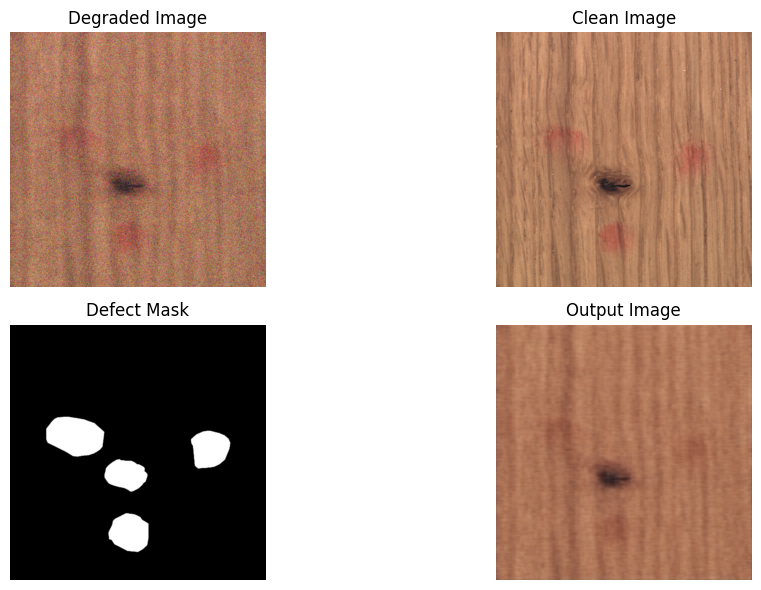

torch.Size([3, 256, 256])


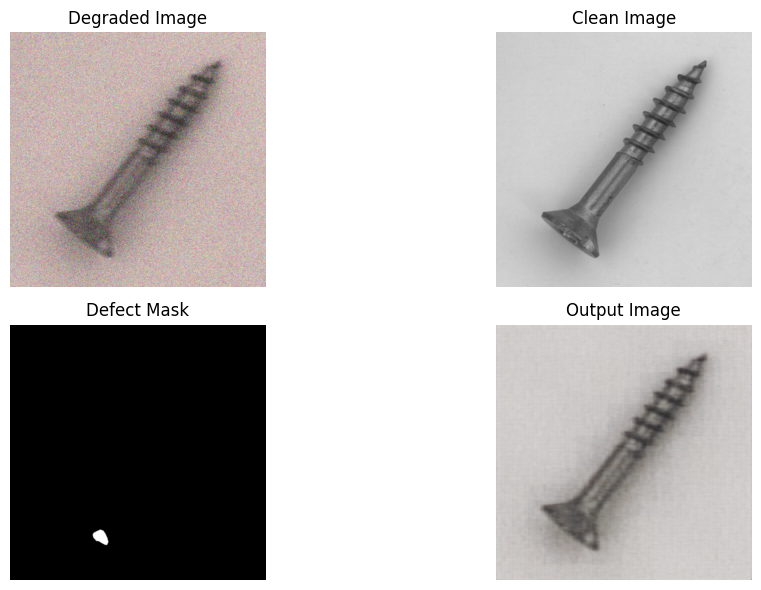

torch.Size([3, 256, 256])


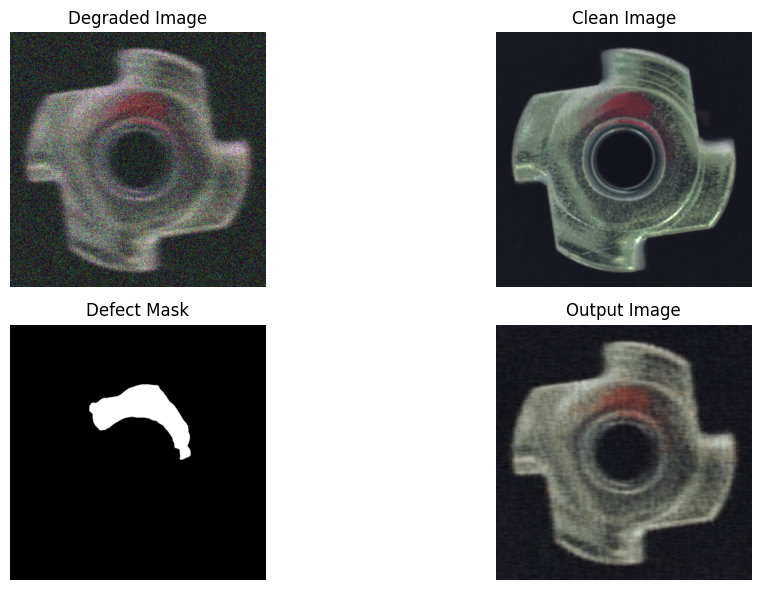

torch.Size([3, 256, 256])


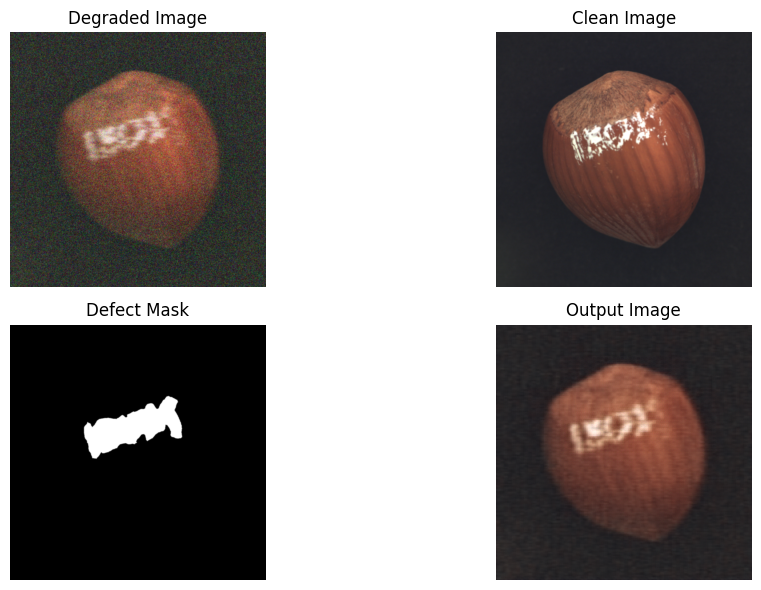

torch.Size([3, 256, 256])


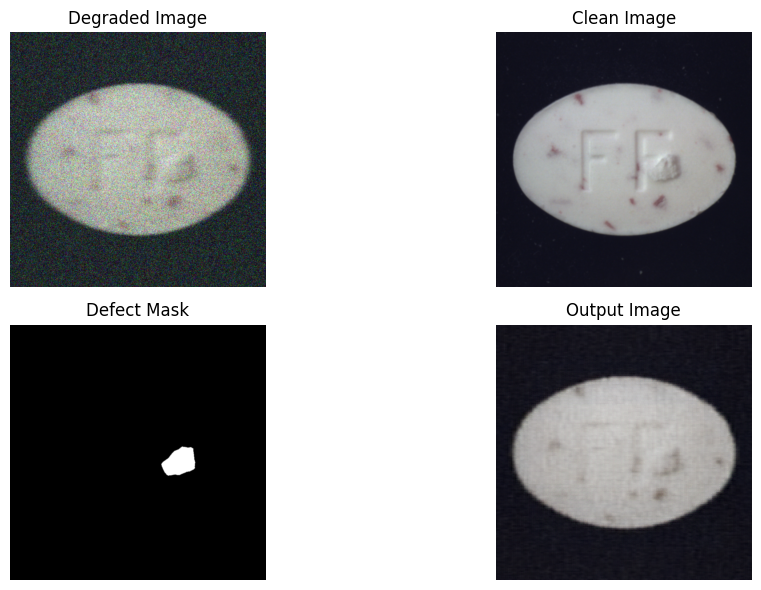

torch.Size([3, 256, 256])


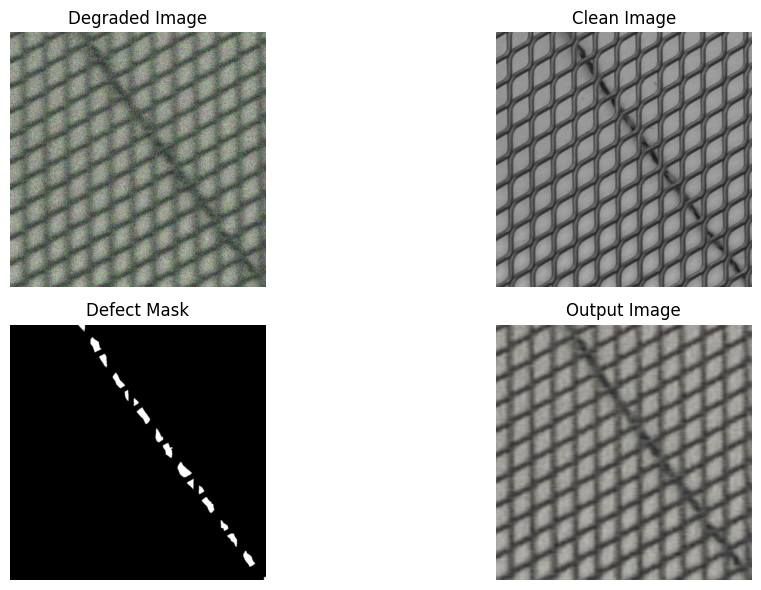

torch.Size([3, 256, 256])


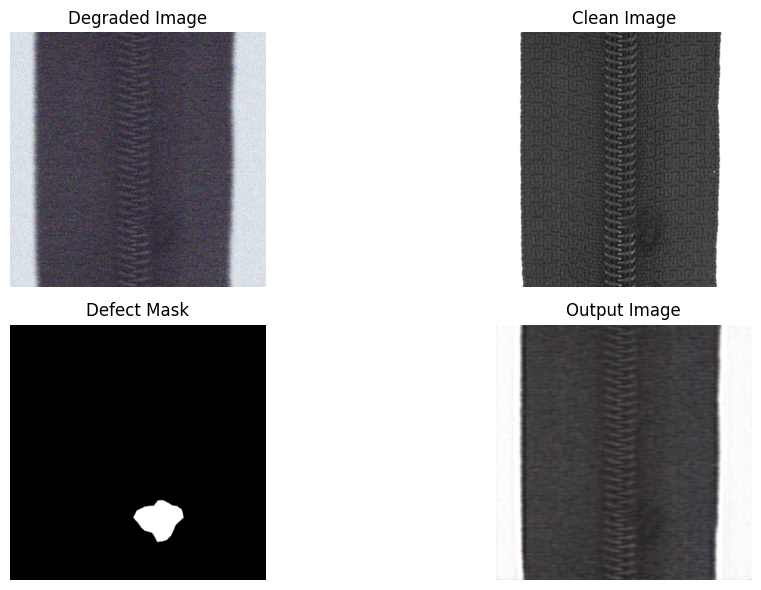

torch.Size([3, 256, 256])


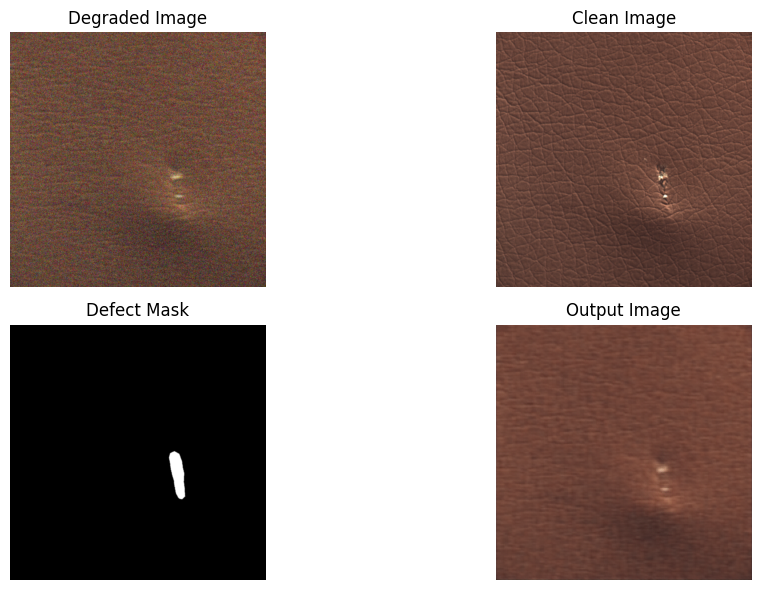

torch.Size([3, 256, 256])


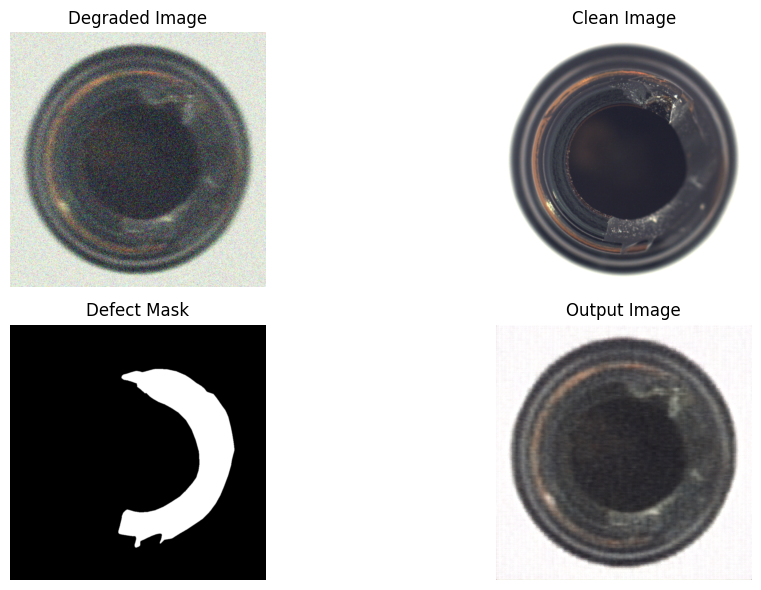

torch.Size([3, 256, 256])


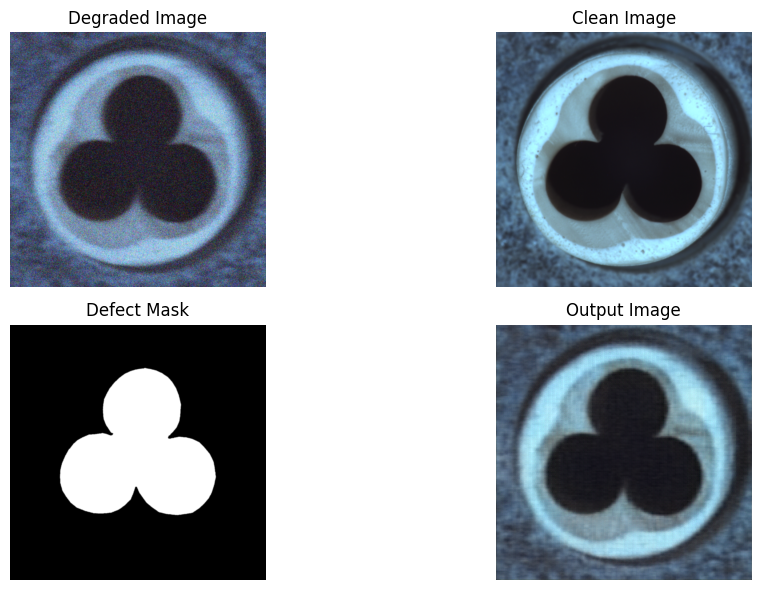

In [33]:
for sample in sample_data:
    degraded, clean, defect_mask = sample
    degraded = degraded.to(device)
    degraded = degraded.unsqueeze(0)
    output_image = model(degraded)
    output_image = output_image.squeeze(0)
    print(output_image.shape)
    display_images(degraded, clean, defect_mask, output_image)